# Alternative comparsion strategies

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.metrics import pairwise
from scipy import stats
import matplotlib.pyplot as plt
from Bio import Phylo
from opencadd.databases.klifs import setup_remote
from kissim.encoding import FingerprintGenerator
from kissim.comparison import tree

from src.paths import PATH_RESULTS
from src.utils import check_distance_matrix

In [3]:
HERE = Path(_dh[-1])  # noqa: F821
DATA = PATH_RESULTS / "dfg_in"

## Functions

In [4]:
def load_fingerprints(path_fingerprints):
    """
    TODO
    """

    kissim_fingerprints = FingerprintGenerator.from_json(path_fingerprints)

    structure_klifs_ids = list(kissim_fingerprints.data.keys())
    session = setup_remote()
    structures = session.structures.by_structure_klifs_id(structure_klifs_ids)
    kinase_names = structures["kinase.klifs_name"].to_list()

    kissim_fingerprints_array = [
        fingerprint.values_array().tolist()
        for structure_klifs_id, fingerprint in kissim_fingerprints.data.items()
    ]
    kissim_fingerprints_array = np.array(kissim_fingerprints_array)
    kissim_fingerprints_df = pd.DataFrame(kissim_fingerprints_array, index=structure_klifs_ids)

    return kissim_fingerprints_df, structure_klifs_ids, kinase_names

In [5]:
def normalize_fingerprints(fingerprints_df, _type):
    """
    TODO
    """

    if _type == "min-max-norm":
        fingerprints_df = (fingerprints_df - fingerprints_df.min()) / (
            fingerprints_df.max() - fingerprints_df.min()
        )
    elif _type == "zscore":
        fingerprints_array = stats.zscore(fingerprints_df.values, nan_policy="omit")
        fingerprints_df = pd.DataFrame(
            fingerprints_array, columns=fingerprints_df.columns, index=fingerprints_df.index
        )
    else:
        raise ValueError("Normalization type not available.")
    return fingerprints_df

In [6]:
def weight_fingerprints(fingerprints_df, w1, w2, w3):
    """
    TODO
    """

    n1 = 85 * 8
    n2 = 85 * 4
    n3 = n1 + n2
    fingerprints_df = pd.concat(
        [
            fingerprints_df.iloc[:, :n1] * w1,
            fingerprints_df.iloc[:, n1:n3] * w2,
            fingerprints_df.iloc[:, n3:] * w3,
        ],
        axis=1,
    )

    return fingerprints_df

In [7]:
def generate_structure_distance_matrix(fingerprints_df):
    """
    TODO
    """

    structure_distance_matrix_array = pairwise.nan_euclidean_distances(fingerprints_df.values)
    # Create DataFrame with structure KLIFS IDs as index/columns
    structure_distance_matrix_df = pd.DataFrame(
        structure_distance_matrix_array, index=structure_klifs_ids, columns=structure_klifs_ids
    )
    print(f"Structure distance matrix size: {structure_distance_matrix_df.shape}")

    structure_distance_matrix_df = structure_distance_matrix_df / len(fingerprints_df)

    return structure_distance_matrix_df

In [8]:
def generate_kinase_distance_matrix(structure_distance_matrix_df):
    """
    TODO
    """

    # Copy distance matrix to kinase matrix
    kinase_distance_matrix_df = structure_distance_matrix_df.copy()
    # Replace structure KLIFS IDs with the structures' kinase names
    kinase_distance_matrix_df.index = kinase_names
    kinase_distance_matrix_df.columns = kinase_names
    # We unstack the matrix (each pairwise comparison in a single row)
    # We group by kinase names (level=[0, 1] ensures that the order of the kinases is ignored
    # We take the minimum value in each kinase pair group
    # We unstack the remaining data points
    kinase_distance_matrix_df = (
        kinase_distance_matrix_df.unstack().groupby(level=[0, 1]).min().unstack(level=1)
    )
    # Cosmetics: Remove the index and column names
    kinase_distance_matrix_df.index.name = None
    kinase_distance_matrix_df.columns.name = None
    return kinase_distance_matrix_df

In [9]:
def generate_tree(kinase_distance_matrix_df):
    """
    TODO
    """

    tree.from_distance_matrix(kinase_distance_matrix_df, "kissim.tree", "kinase_annotation.csv")

    groups_to_color = {
        "AGC": "red",
        "Atypical": "orange",
        "CAMK": "yellowgreen",
        "CK1": "limegreen",
        "CMGC": "turquoise",
        "Other": "cornflowerblue",
        "STE": "mediumblue",
        "TK": "darkorchid",
        "TKL": "violet",
    }

    kinases_to_groups = pd.read_csv(Path("kinase_annotation.csv"), sep="\t")
    kinases_to_groups["color"] = kinases_to_groups.apply(
        lambda x: groups_to_color[x["kinase.group"]], axis=1
    )
    label_colors = kinases_to_groups.set_index("kinase.klifs_name")["color"].to_dict()

    kissim_tree = Phylo.read(Path("kissim.tree"), "newick")
    # Flip branches so deeper clades are displayed at top
    kissim_tree.ladderize()

    fig, ax = plt.subplots(1, 1, figsize=(5, 40))
    Phylo.draw(kissim_tree, axes=ax, label_colors=label_colors)

In [10]:
def pipeline(kissim_fingerprints_df, norm_type, weights):
    """
    TODO
    """

    print("Fingerprints ", kissim_fingerprints_df.shape)
    # Normalize
    kissim_fingerprints_df = normalize_fingerprints(kissim_fingerprints_df, "zscore")
    print("Normalized fingerprints ", kissim_fingerprints_df.shape)
    # Weights
    kissim_fingerprints_df = weight_fingerprints(
        kissim_fingerprints_df, weights[0], weights[1], weights[2]
    )
    print("Weighted fingerprints ", kissim_fingerprints_df.shape)
    # Structure distance matrix
    structure_distance_matrix_df = generate_structure_distance_matrix(kissim_fingerprints_df)
    structure_distance_matrix_df = structure_distance_matrix_df.round(6)
    print("Structure distance matrix ", structure_distance_matrix_df.shape)
    # Kinase distance matrix
    kinase_distance_matrix_df = generate_kinase_distance_matrix(structure_distance_matrix_df)
    print("Kinase distance matrix ", kinase_distance_matrix_df.shape)
    # Distance matrix checks
    check_distance_matrix(kinase_distance_matrix_df.values)
    # Generate tree
    generate_tree(kinase_distance_matrix_df)

## Load fingerprints

In [11]:
%%time
kissim_fingerprints_df, structure_klifs_ids, kinase_names = load_fingerprints(
    DATA / "fingerprints.json"
)
kissim_fingerprints_df.head()

CPU times: user 6.52 s, sys: 169 ms, total: 6.69 s
Wall time: 7.54 s


,0,1,2,3,4,5,6,7,8,9,...,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031
4,3.0,3.0,0.0,1.0,0.0,0.0,3.0,3.0,1.0,0.0,...,12.914635,11.895509,4.362040,4.846801,4.116410,3.320343,2.799997,3.283490,3.185355,1.958556
8,2.0,1.0,1.0,0.0,0.0,0.0,3.0,3.0,2.0,0.0,...,12.890831,11.917021,4.457056,4.618724,4.235016,3.315980,3.047669,2.983281,3.011761,1.552540
9,2.0,1.0,1.0,0.0,0.0,0.0,3.0,3.0,2.0,0.0,...,13.590229,12.481196,4.673707,4.819141,4.920843,3.584839,1.806368,3.782832,3.993346,-0.972571
11,2.0,1.0,1.0,0.0,0.0,0.0,3.0,3.0,2.0,0.0,...,13.176483,12.211066,4.515666,4.692519,4.223252,3.375414,2.274370,3.711405,2.914254,1.409469
12,2.0,1.0,1.0,0.0,0.0,0.0,2.0,3.0,2.0,0.0,...,13.018169,11.955774,4.504900,4.645471,4.280999,3.309719,2.942617,3.083737,3.066983,1.505466


## Generate trees

Fingerprints  (4112, 1032)
Normalized fingerprints  (4112, 1032)
Weighted fingerprints  (4112, 1032)
Structure distance matrix size: (4112, 4112)
Structure distance matrix  (4112, 4112)
Kinase distance matrix  (257, 257)
Matrix 2D and square?:        True
Matrix positive?:             True
Matrix diagonale 0?:          True
Matrix symmetric?:            True
Triangular inequality?:       True


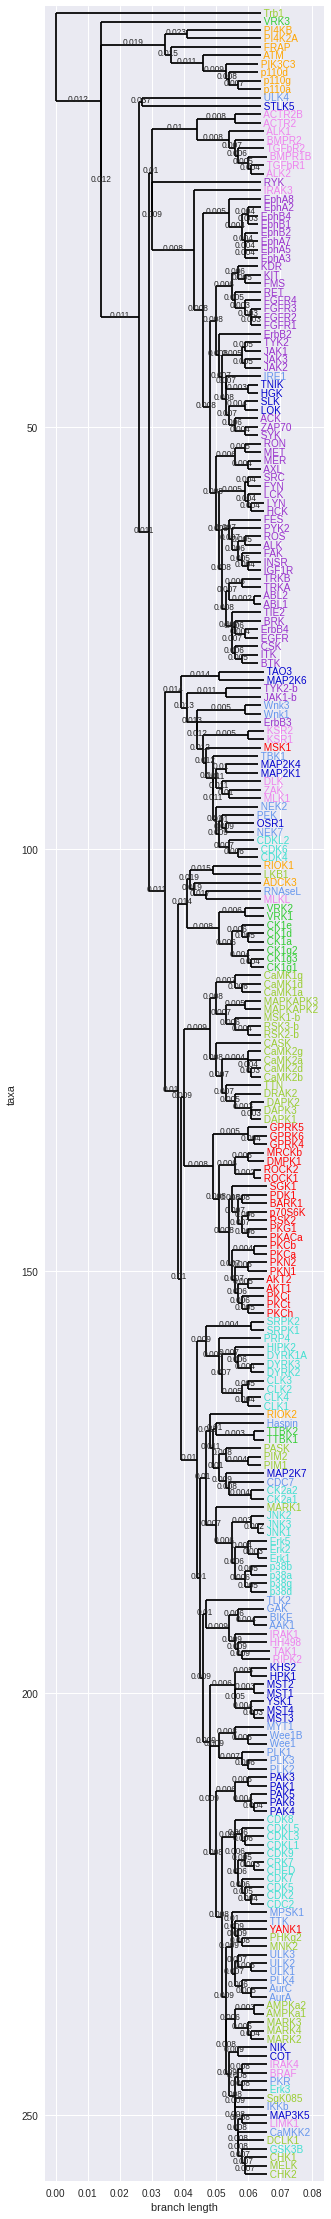

CPU times: user 40.9 s, sys: 1.29 s, total: 42.1 s
Wall time: 37.7 s


In [12]:
%%time
pipeline(kissim_fingerprints_df, "min-max-norm", [1, 1, 1])

Fingerprints  (4112, 1032)
Normalized fingerprints  (4112, 1032)
Weighted fingerprints  (4112, 1032)
Structure distance matrix size: (4112, 4112)
Structure distance matrix  (4112, 4112)
Kinase distance matrix  (257, 257)
Matrix 2D and square?:        True
Matrix positive?:             True
Matrix diagonale 0?:          True
Matrix symmetric?:            True
Triangular inequality?:       True


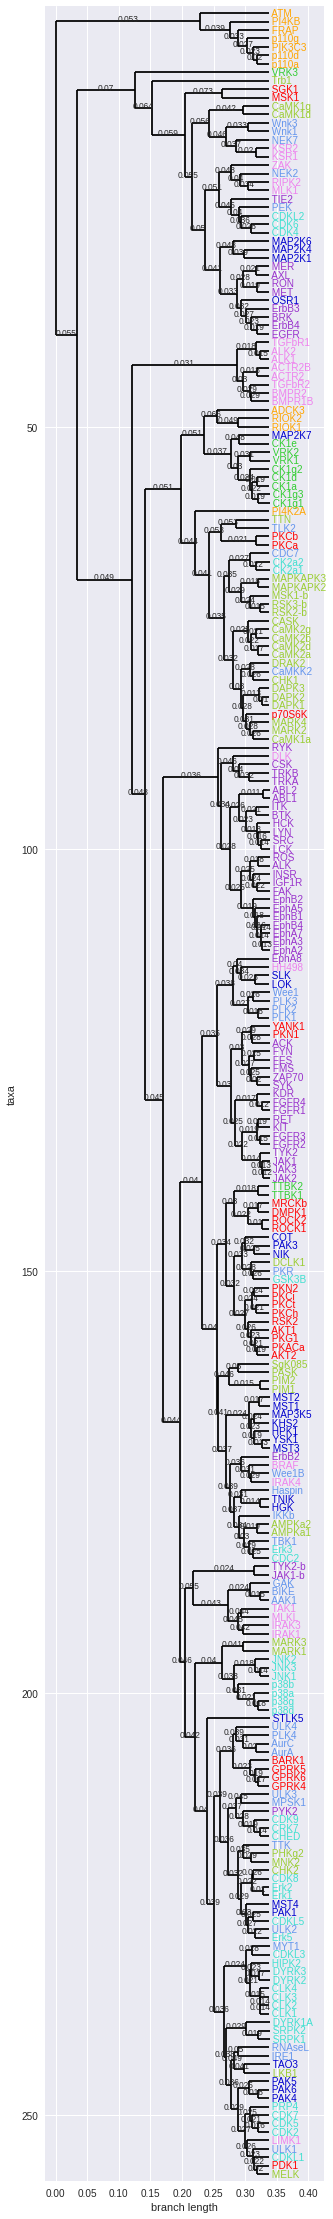

CPU times: user 42 s, sys: 1.64 s, total: 43.7 s
Wall time: 38.7 s


In [13]:
%%time
pipeline(kissim_fingerprints_df, "min-max-norm", [1, 10, 1])

Fingerprints  (4112, 1032)
Normalized fingerprints  (4112, 1032)
Weighted fingerprints  (4112, 1032)
Structure distance matrix size: (4112, 4112)
Structure distance matrix  (4112, 4112)
Kinase distance matrix  (257, 257)
Matrix 2D and square?:        True
Matrix positive?:             True
Matrix diagonale 0?:          True
Matrix symmetric?:            True
Triangular inequality?:       True


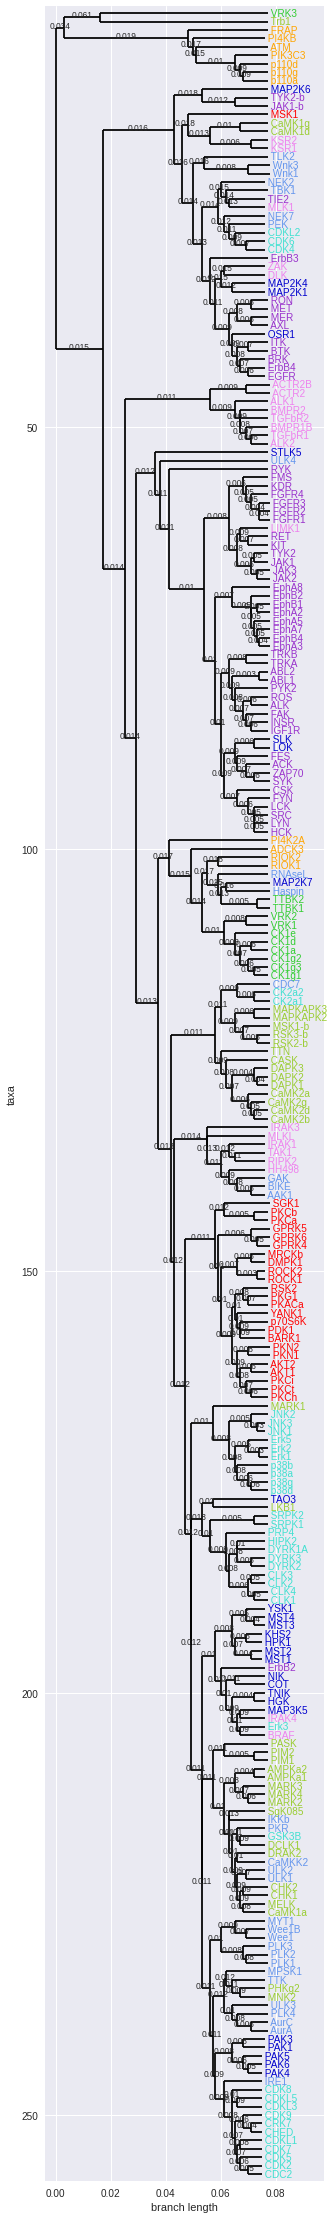

CPU times: user 42.2 s, sys: 1.46 s, total: 43.7 s
Wall time: 39 s


In [14]:
%%time
pipeline(kissim_fingerprints_df, "zscore", [1, 2, 2])

Fingerprints  (4112, 1032)
Normalized fingerprints  (4112, 1032)
Weighted fingerprints  (4112, 1032)
Structure distance matrix size: (4112, 4112)
Structure distance matrix  (4112, 4112)
Kinase distance matrix  (257, 257)
Matrix 2D and square?:        True
Matrix positive?:             True
Matrix diagonale 0?:          True
Matrix symmetric?:            True
Triangular inequality?:       True


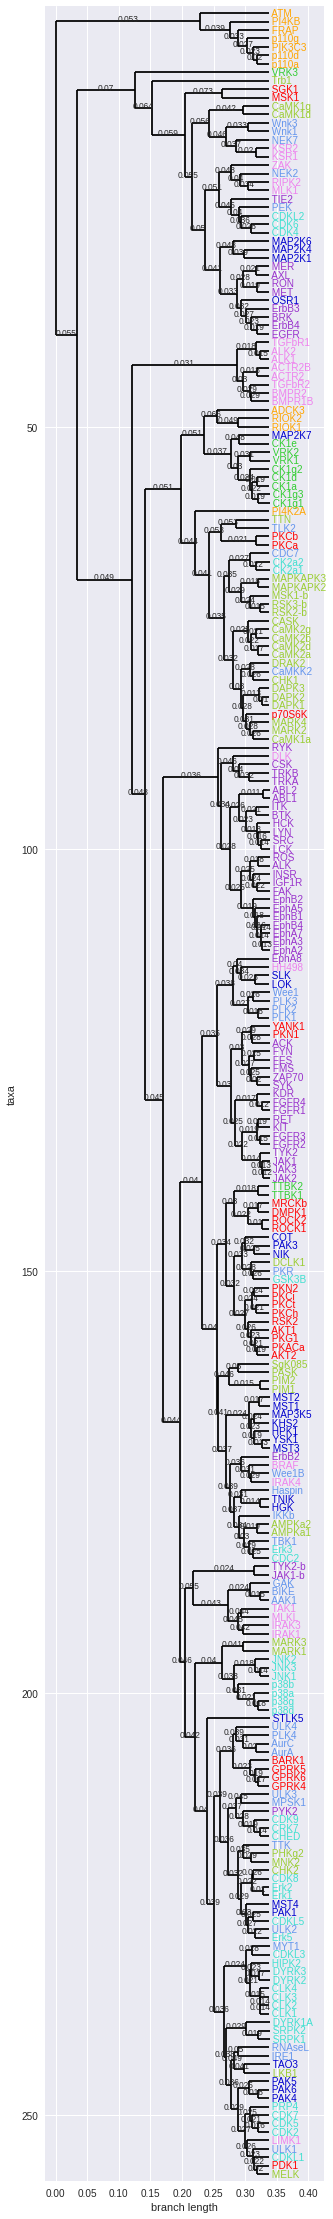

CPU times: user 42.3 s, sys: 1.37 s, total: 43.7 s
Wall time: 39 s


In [15]:
%%time
pipeline(kissim_fingerprints_df, "zscore", [1, 10, 1])